In [1]:
%config InlineBackend.figure_formats = ["retina"]

In [17]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import us

from shapely.geometry import Point

In [ ]:
census = Census("", year=2020)

## ACS migration flows

In [3]:
raw_flows = requests.get(
    "https://web.archive.org/web/20241226165446if_/https://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2020/county-to-county-migration-2016-2020/county-to-county-migration-flows/Net_Gross_US.txt"
).content.decode("latin1").split("\n")

In [4]:
raw_flows[0]

'001001001003 Alabama                       Autauga County                      Alabama                       Baldwin County                            30       37      489      395     -459      396      519      398 '

In [5]:
# from equivalent Excel spreadsheet
place_columns = (
    "a_fips",
    "b_fips",
    "a_state",
    "a_county",
    "b_state",
    "b_county",
)

flow_columns = (
    "b_to_a_flow_est",
    "b_to_a_flow_moe",
    "a_to_b_flow_est",
    "a_to_b_moe",
    "net_flow_est",
    "net_flow_moe",
    "gross_flow_est",
    "gross_flow_moe",
)

columns = (*place_columns, *flow_columns)

In [6]:
flows = []
for raw_flow in raw_flows[:-1]:
    flow_id = raw_flow[:raw_flow.index(" ")]
    if not all(c.isdigit() for c in flow_id):
        continue  # skip non-county flows
        
    assert len(flow_id) == 12, flow_id
    a_fips = flow_id[1:6]
    b_fips = flow_id[7:]

    remainder = raw_flow[raw_flow.index(" "):]
    parts = [a_fips, b_fips] + [part.strip() for part in remainder.split("  ") if part.strip()]
    flows.append({col: val for col, val in zip(columns, parts)})

In [7]:
flow_df = pd.DataFrame(flows).set_index(["a_fips", "b_fips"])
for col in flow_columns:
    flow_df[col] = flow_df[col].astype(int)

In [8]:
assert not flow_df["a_to_b_flow_est"].isna().sum()

In [9]:
nyc_county_fips_codes = {
    "The Bronx": "36005",      # Bronx County
    "Brooklyn": "36047",       # Kings County
    "Manhattan": "36061",      # New York County
    "Queens": "36081",         # Queens County
    "Staten Island": "36085",  # Richmond
}

In [10]:
county_gdf = gpd.read_file("https://web.archive.org/web/20241002004532if_/https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/tl_2024_us_county.zip").set_index("GEOID").to_crs("EPSG:2163")

In [11]:
nyc_county_gdf = county_gdf.loc[nyc_county_fips_codes.values()]

In [12]:
migration_graph = nx.DiGraph()
net_migration_graph = nx.DiGraph()

for a_county, a_county_fips in nyc_county_fips_codes.items():
    for b_county, b_county_fips in nyc_county_fips_codes.items():
        if a_county == b_county:
            continue
            
        flow = flow_df.loc[(a_county_fips, b_county_fips)]        
        net_flow = flow["net_flow_est"]
        if net_flow >= 0:
            net_migration_graph.add_edge(
                a_county,
                b_county,
                weight=net_flow,
            )
        else:
            net_migration_graph.add_edge(
                b_county,
                a_county,
                weight=-net_flow,
            )

In [13]:
def cast_point(p):
    return (p.xy[0][0], p.xy[1][0])

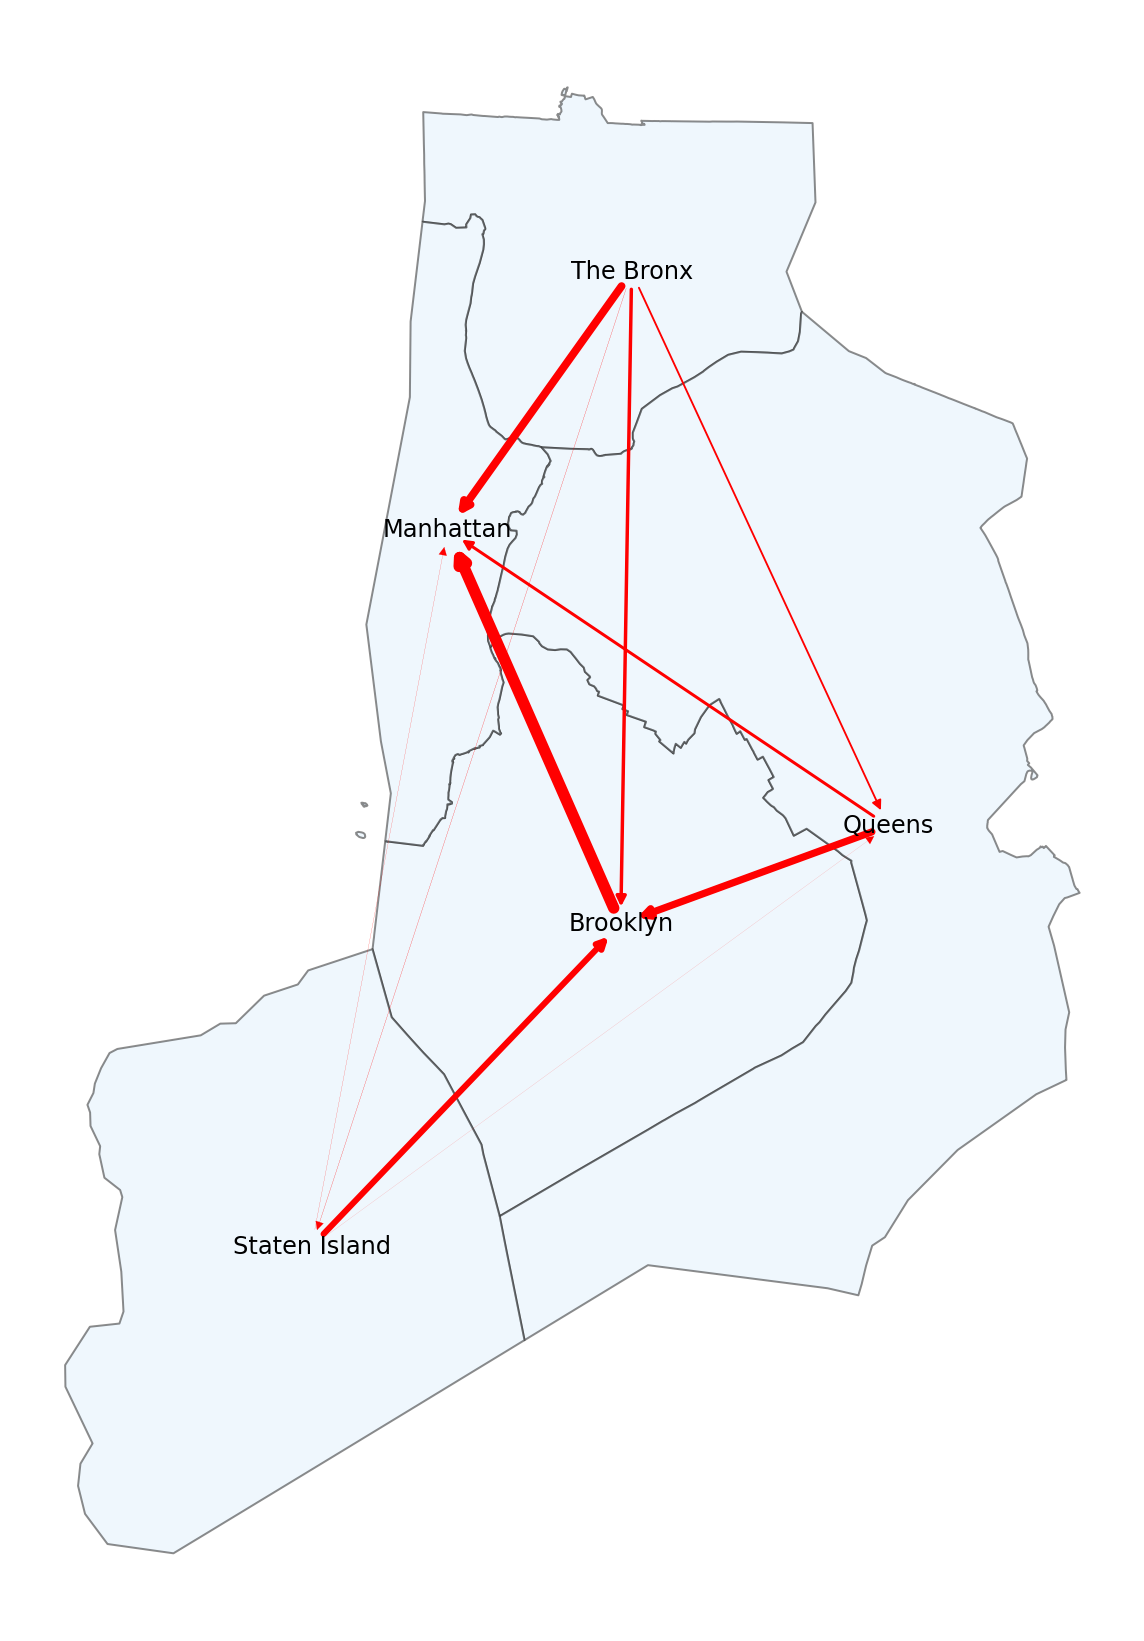

In [14]:
fig, ax = plt.subplots(figsize=(10, 20))
ax.axis("off")
nyc_county_gdf.plot(ax=ax, edgecolor="0.1", linewidth=1, color="#e1f1fd", alpha=0.5)

pos = {
    borough: cast_point(nyc_county_gdf.loc[county_fips].geometry.representative_point())
    for borough, county_fips in nyc_county_fips_codes.items()
}   
#nx.draw_networkx_nodes(net_migration_graph, pos, ax=ax)
nx.draw_networkx_labels(net_migration_graph, pos, ax=ax)

for edge in net_migration_graph.edges(data='weight'):
    nx.draw_networkx_edges(net_migration_graph, pos, edgelist=[edge], width=0.0006 * edge[2], ax=ax, edge_color="red")

### Migration and opportunity

In [15]:
# Estimate!!Median age --!!Total:
median_age_column = "B01002_001E"

# Estimate!!Median income in the past 12 months --!!Total:
median_income_column = "B06011_001E"

In [16]:
county_tract_acs_df = pd.DataFrame(
    census.acs5.get(
        (median_age_column, median_income_column),
        geo={
            "for": "county:*",
            "in": f"state:{state_fips}",
        },
        year=2020,
    )
)

NameError: name 'census' is not defined

(TODO...)

## PUMS migration flows

In [160]:
rac1p = {
    "1": "white",  # White alone
    "2": "black",  # Black or African American alone
    "3": "amin",   # "American Indian alone",
    "4": "amin",   # Alaska Native alone
    "5": "amin",   # "American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",
    "6": "aapi",   # "Asian alone",
    "7": "aapi",   # "Native Hawaiian and Other Pacific Islander alone",
    "8": "other",  # "Some other race alone",
    "9": "two_or_more",  # "Two or More Races"
}

In [ ]:
pums_results = []
puma_gdfs = []

for state in us.states.STATES:
    print(state)

    state_pums_response = requests.get(
        "https://api.census.gov/data/2023/acs/acs1/pums"
        f"?get=MIGSP,MIGPUMA,RAC1P&for=public%20use%20microdata%20area:*&in=state:{state.fips}"
    ).json()
    pums_results += state_pums_response[1:]
    
    puma_gdfs.append(
        gpd.read_file(
            f"https://www2.census.gov/geo/tiger/TIGER2024/PUMA20/tl_2024_{state.fips}_puma20.zip"
        )
    )

In [66]:
json.dump(pums_results, open("pums_results.json", "w"))

In [122]:
pumas_gdf = gpd.GeoDataFrame(pd.concat(puma_gdfs), crs=puma_gdfs[0].crs).set_index("GEOID20")

In [123]:
puma_points_gdf = gpd.GeoDataFrame(
    {
        "geometry": pumas_gdf.apply(
            lambda row: Point(float(row["INTPTLON20"]), float(row["INTPTLAT20"])),
            axis=1,
        )
    },
    crs=pumas_gdf.crs,
)

In [124]:
puma_points_gdf

,geometry
GEOID20,
0101700,POINT (-86.94619 32.40589)
0100100,POINT (-87.77501 34.69610)
0100200,POINT (-86.98140 34.81024)
0101000,POINT (-87.36030 34.12802)
0102400,POINT (-85.81365 31.41684)
...,...
5600100,POINT (-109.29807 43.96458)
5600200,POINT (-105.42705 43.65181)
5600300,POINT (-104.66039 41.29283)


In [74]:
excluded_migpumas = (
    "00001",  # Did not live in the United States or in Puerto Rico one year ago
    "00002",  # Lived in Puerto Rico one year ago and current residence is in the United States
    "N",      # N/A (person less than 1 year old/lived in same house 1 year ago)
)

In [85]:
puma_df = pd.DataFrame(pums_results, columns=["migsp", "migpuma", "race", "state", "puma"])
puma_df["race"] = puma_df["race"].map(rac1p)

In [198]:
puma_flows_df = puma_df[puma_df["migsp"].str.startswith("0")].copy()
puma_flows_df["from"] = puma_flows_df["migsp"].str.slice(1) + puma_flows_df["migpuma"]
puma_flows_df["to"] = puma_df["state"] + puma_flows_df["puma"]
puma_flows_df = puma_flows_df[["from", "to", "race"]]
puma_flows_df

,from,to,race
3,0102700,0102702,black
4,1703100,0102802,white
6,0101890,0101801,black
9,0101503,0102802,white
10,0102800,0102803,black
...,...,...,...
3399032,0801000,5600300,white
3399049,5600400,5600300,white
3399050,5600400,5600300,white
3399064,4201700,5600200,white


In [94]:
state_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/STATE/tl_2024_us_state.zip").set_index("GEOID").to_crs("EPSG:2163")

In [150]:
proj_puma_points = dict(puma_points_gdf.to_crs("EPSG:2163")["geometry"])

In [271]:
flow_state = "06"

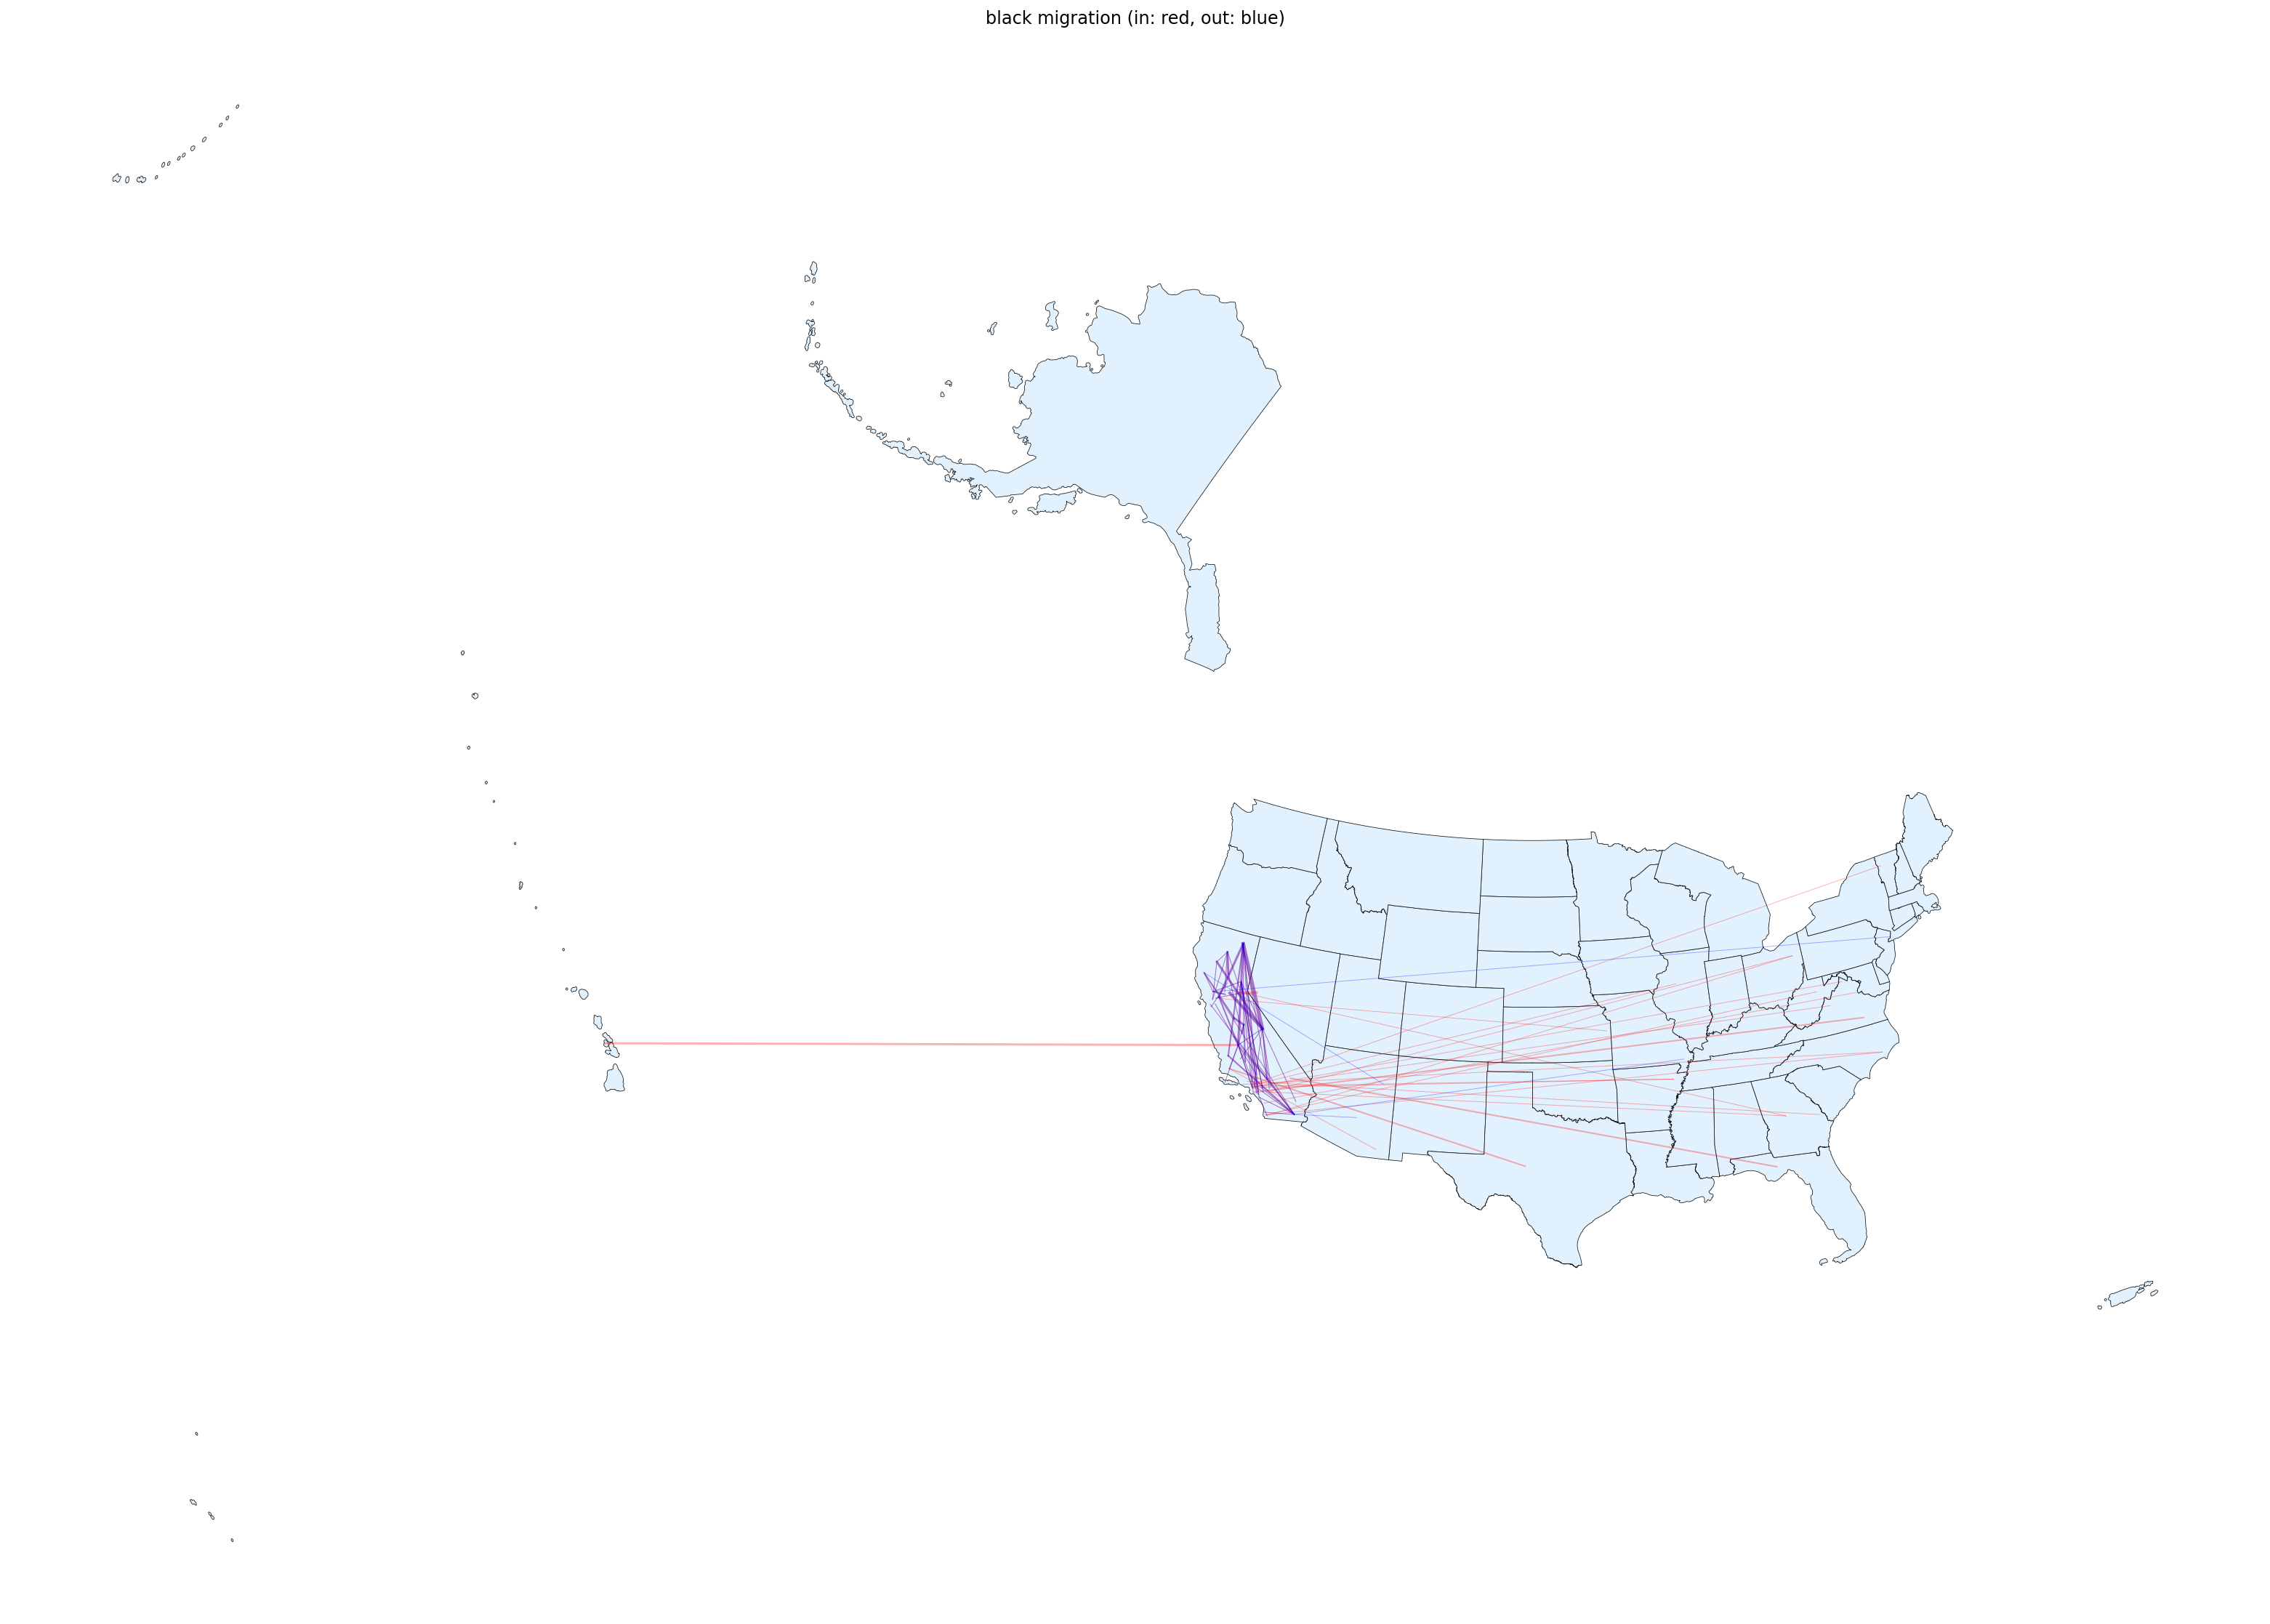

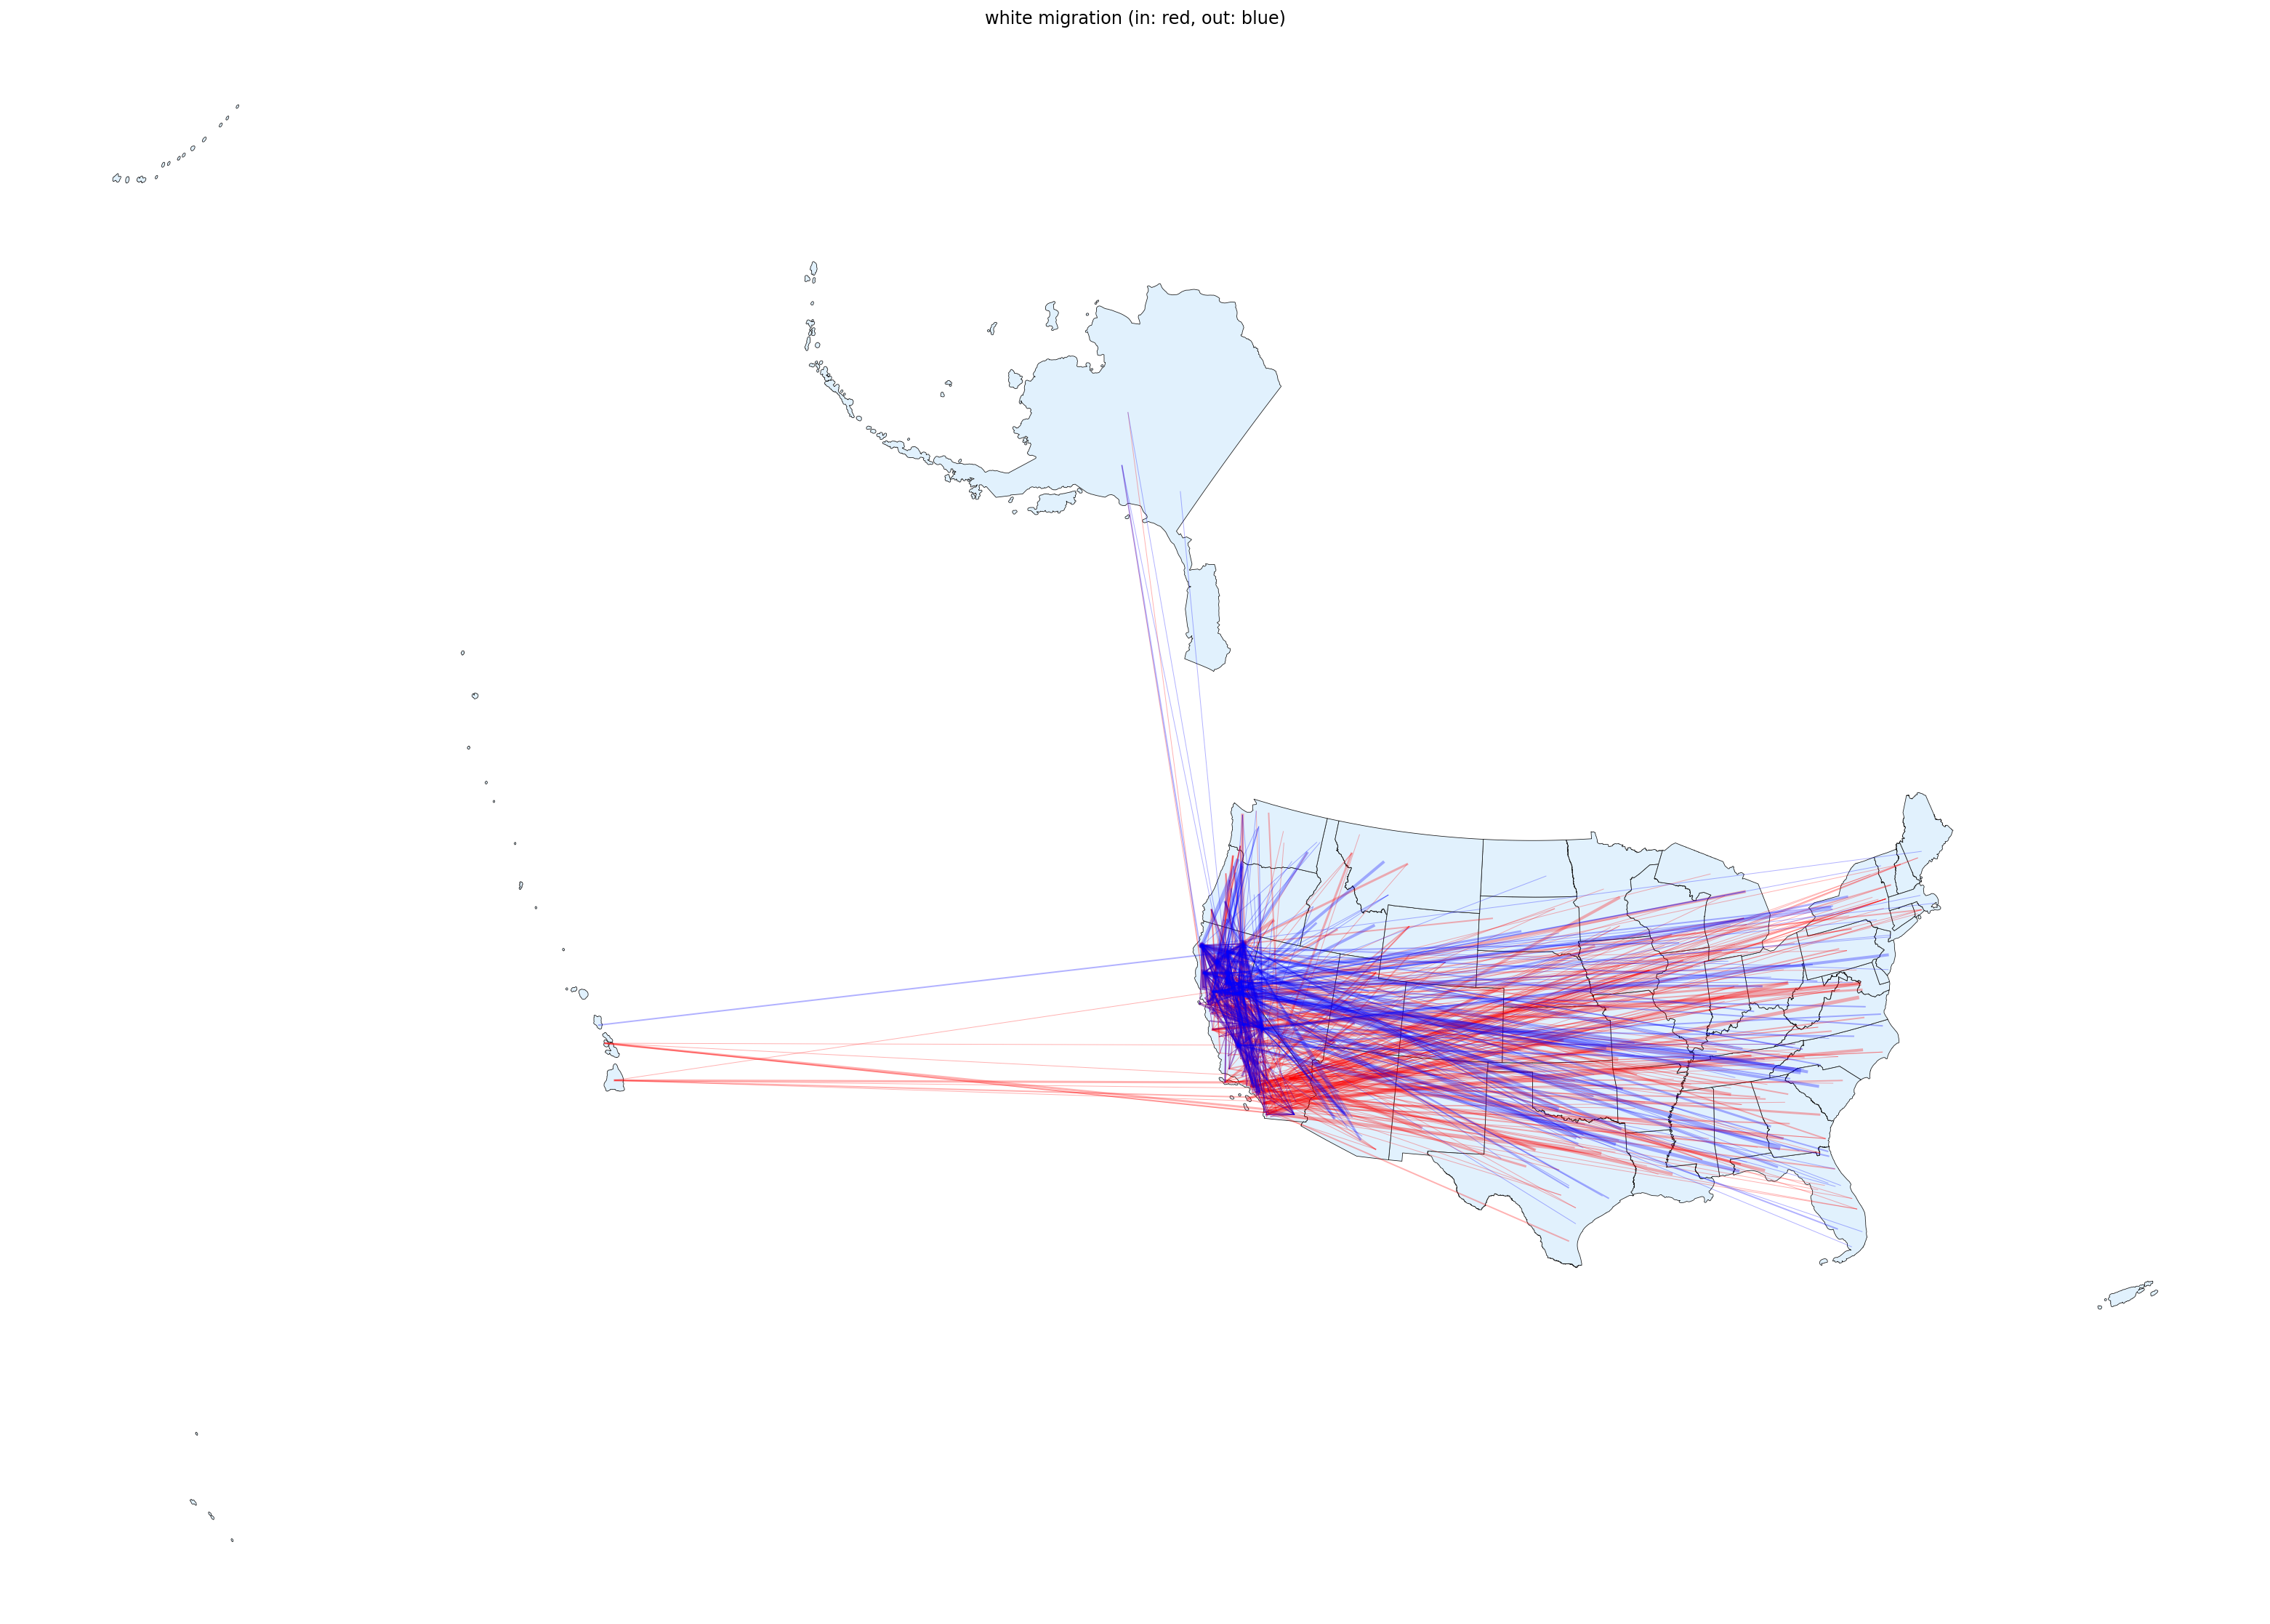

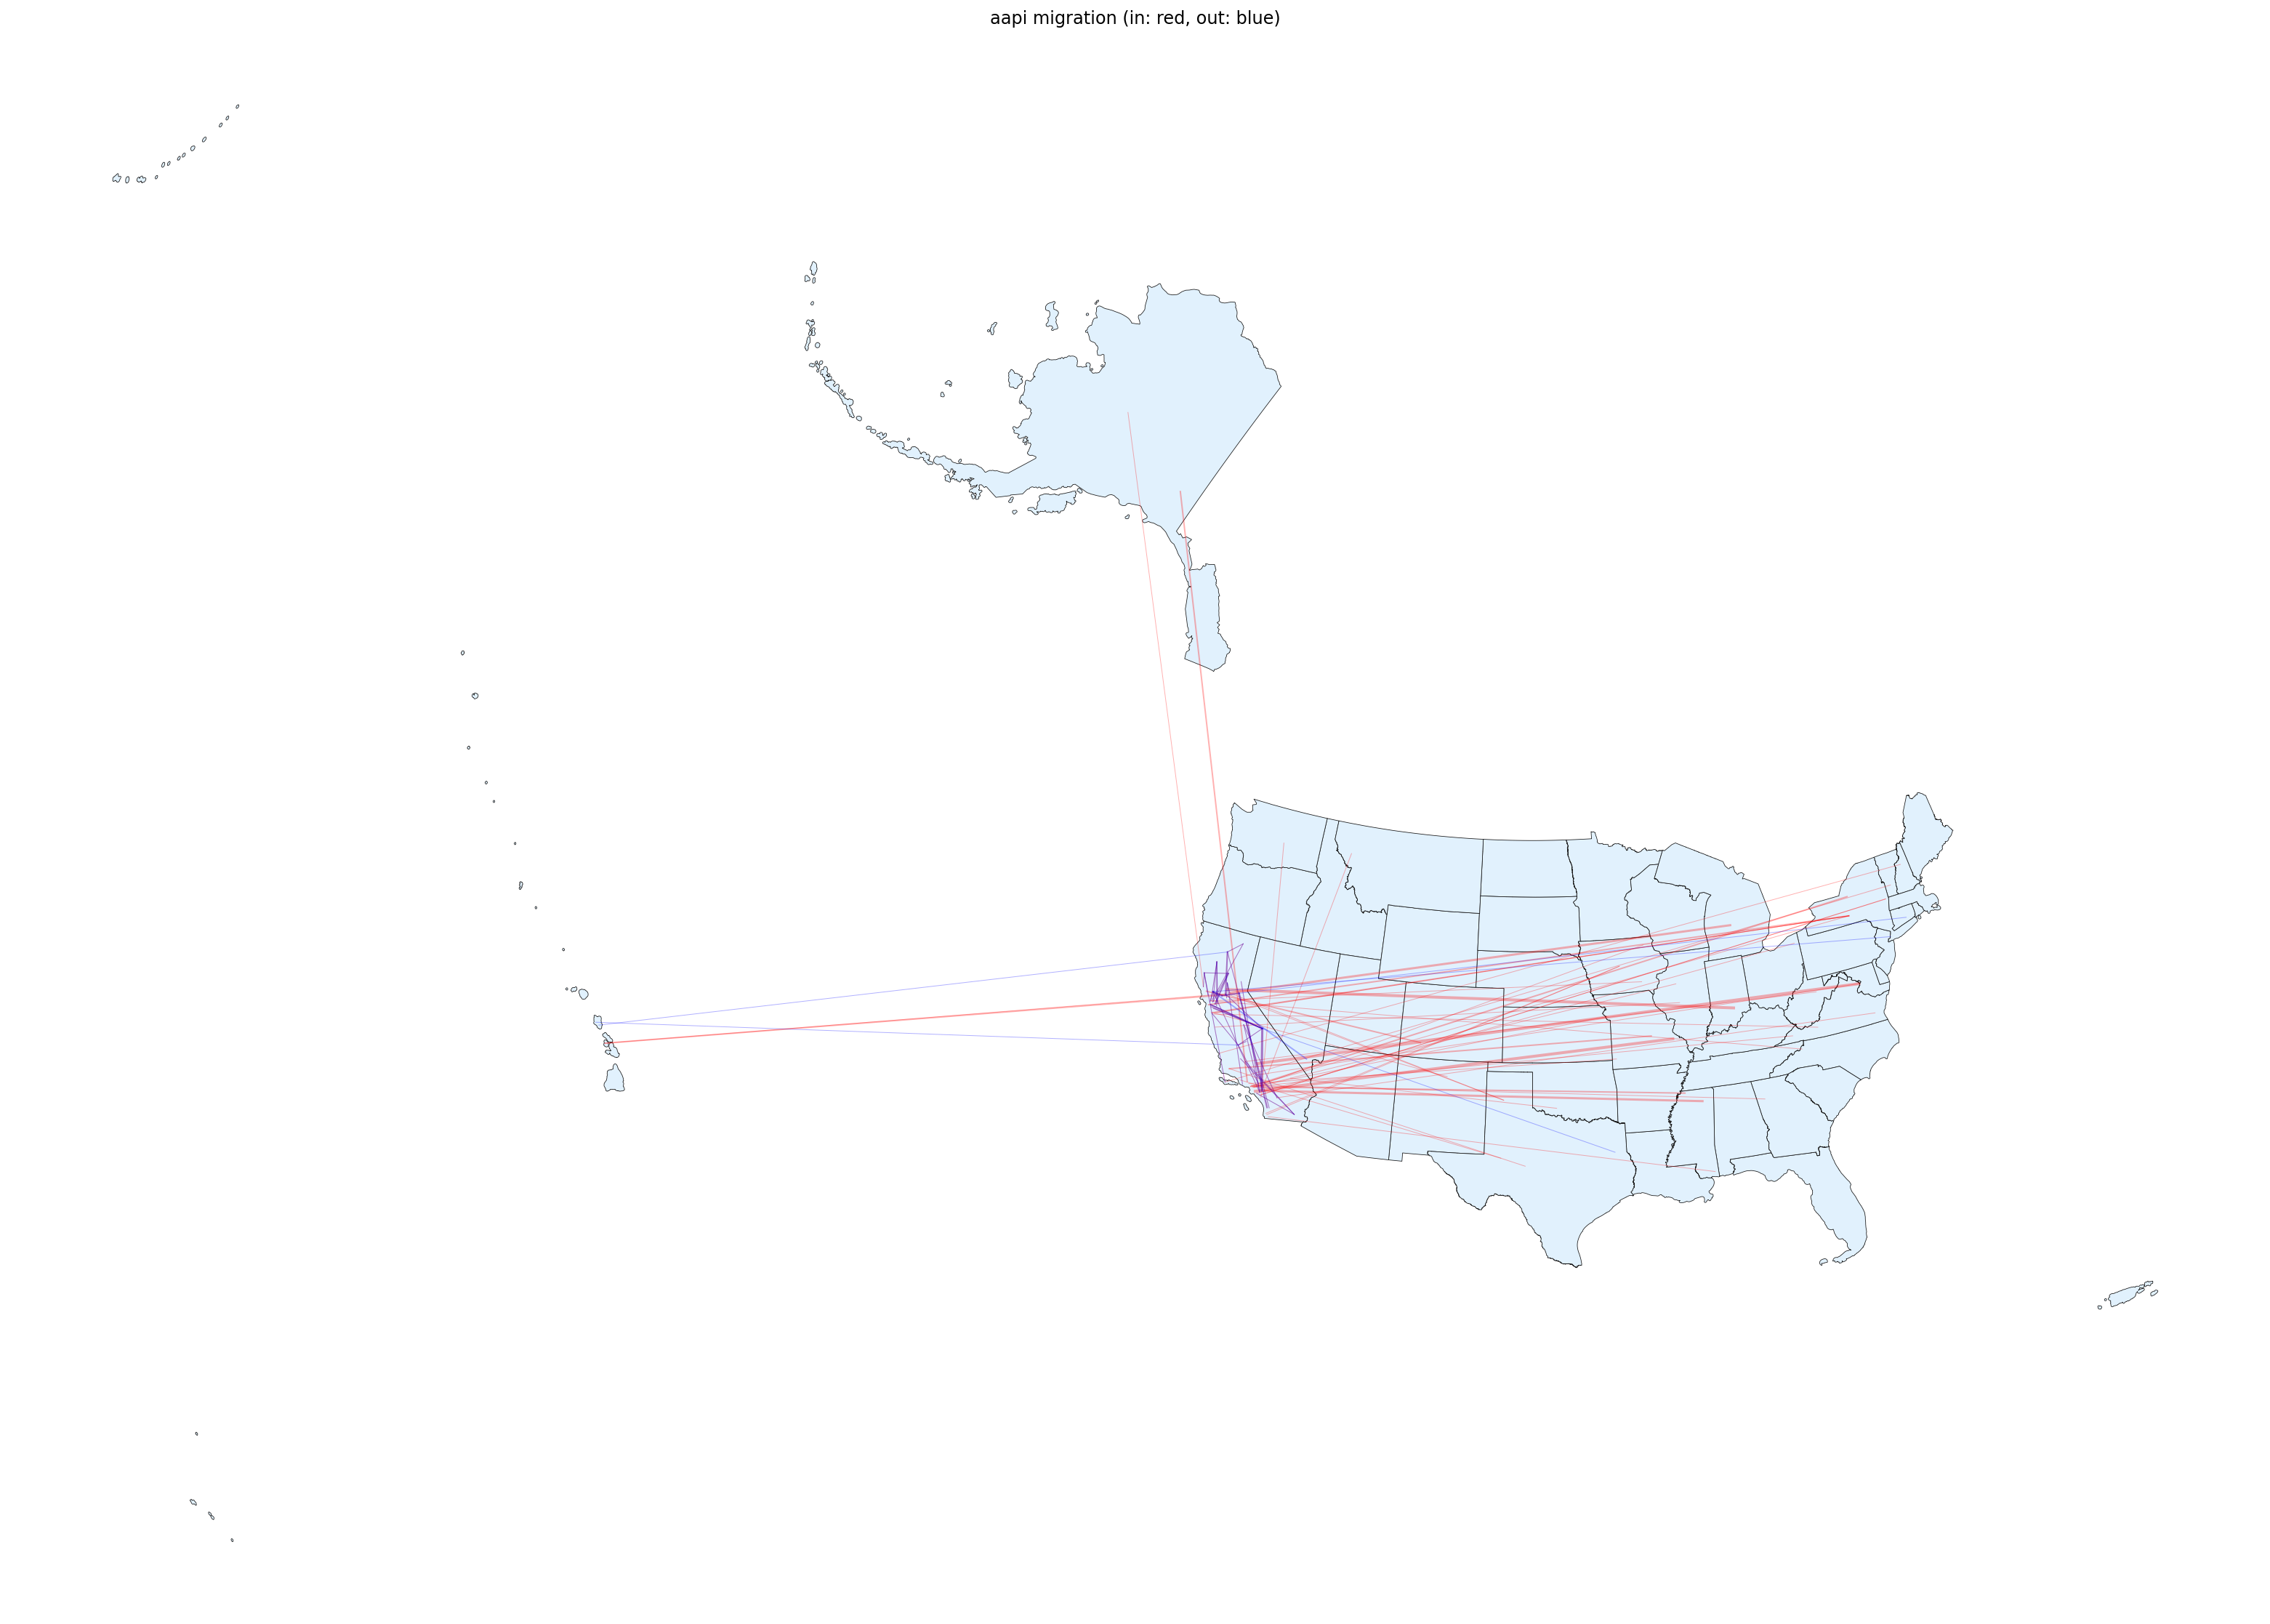

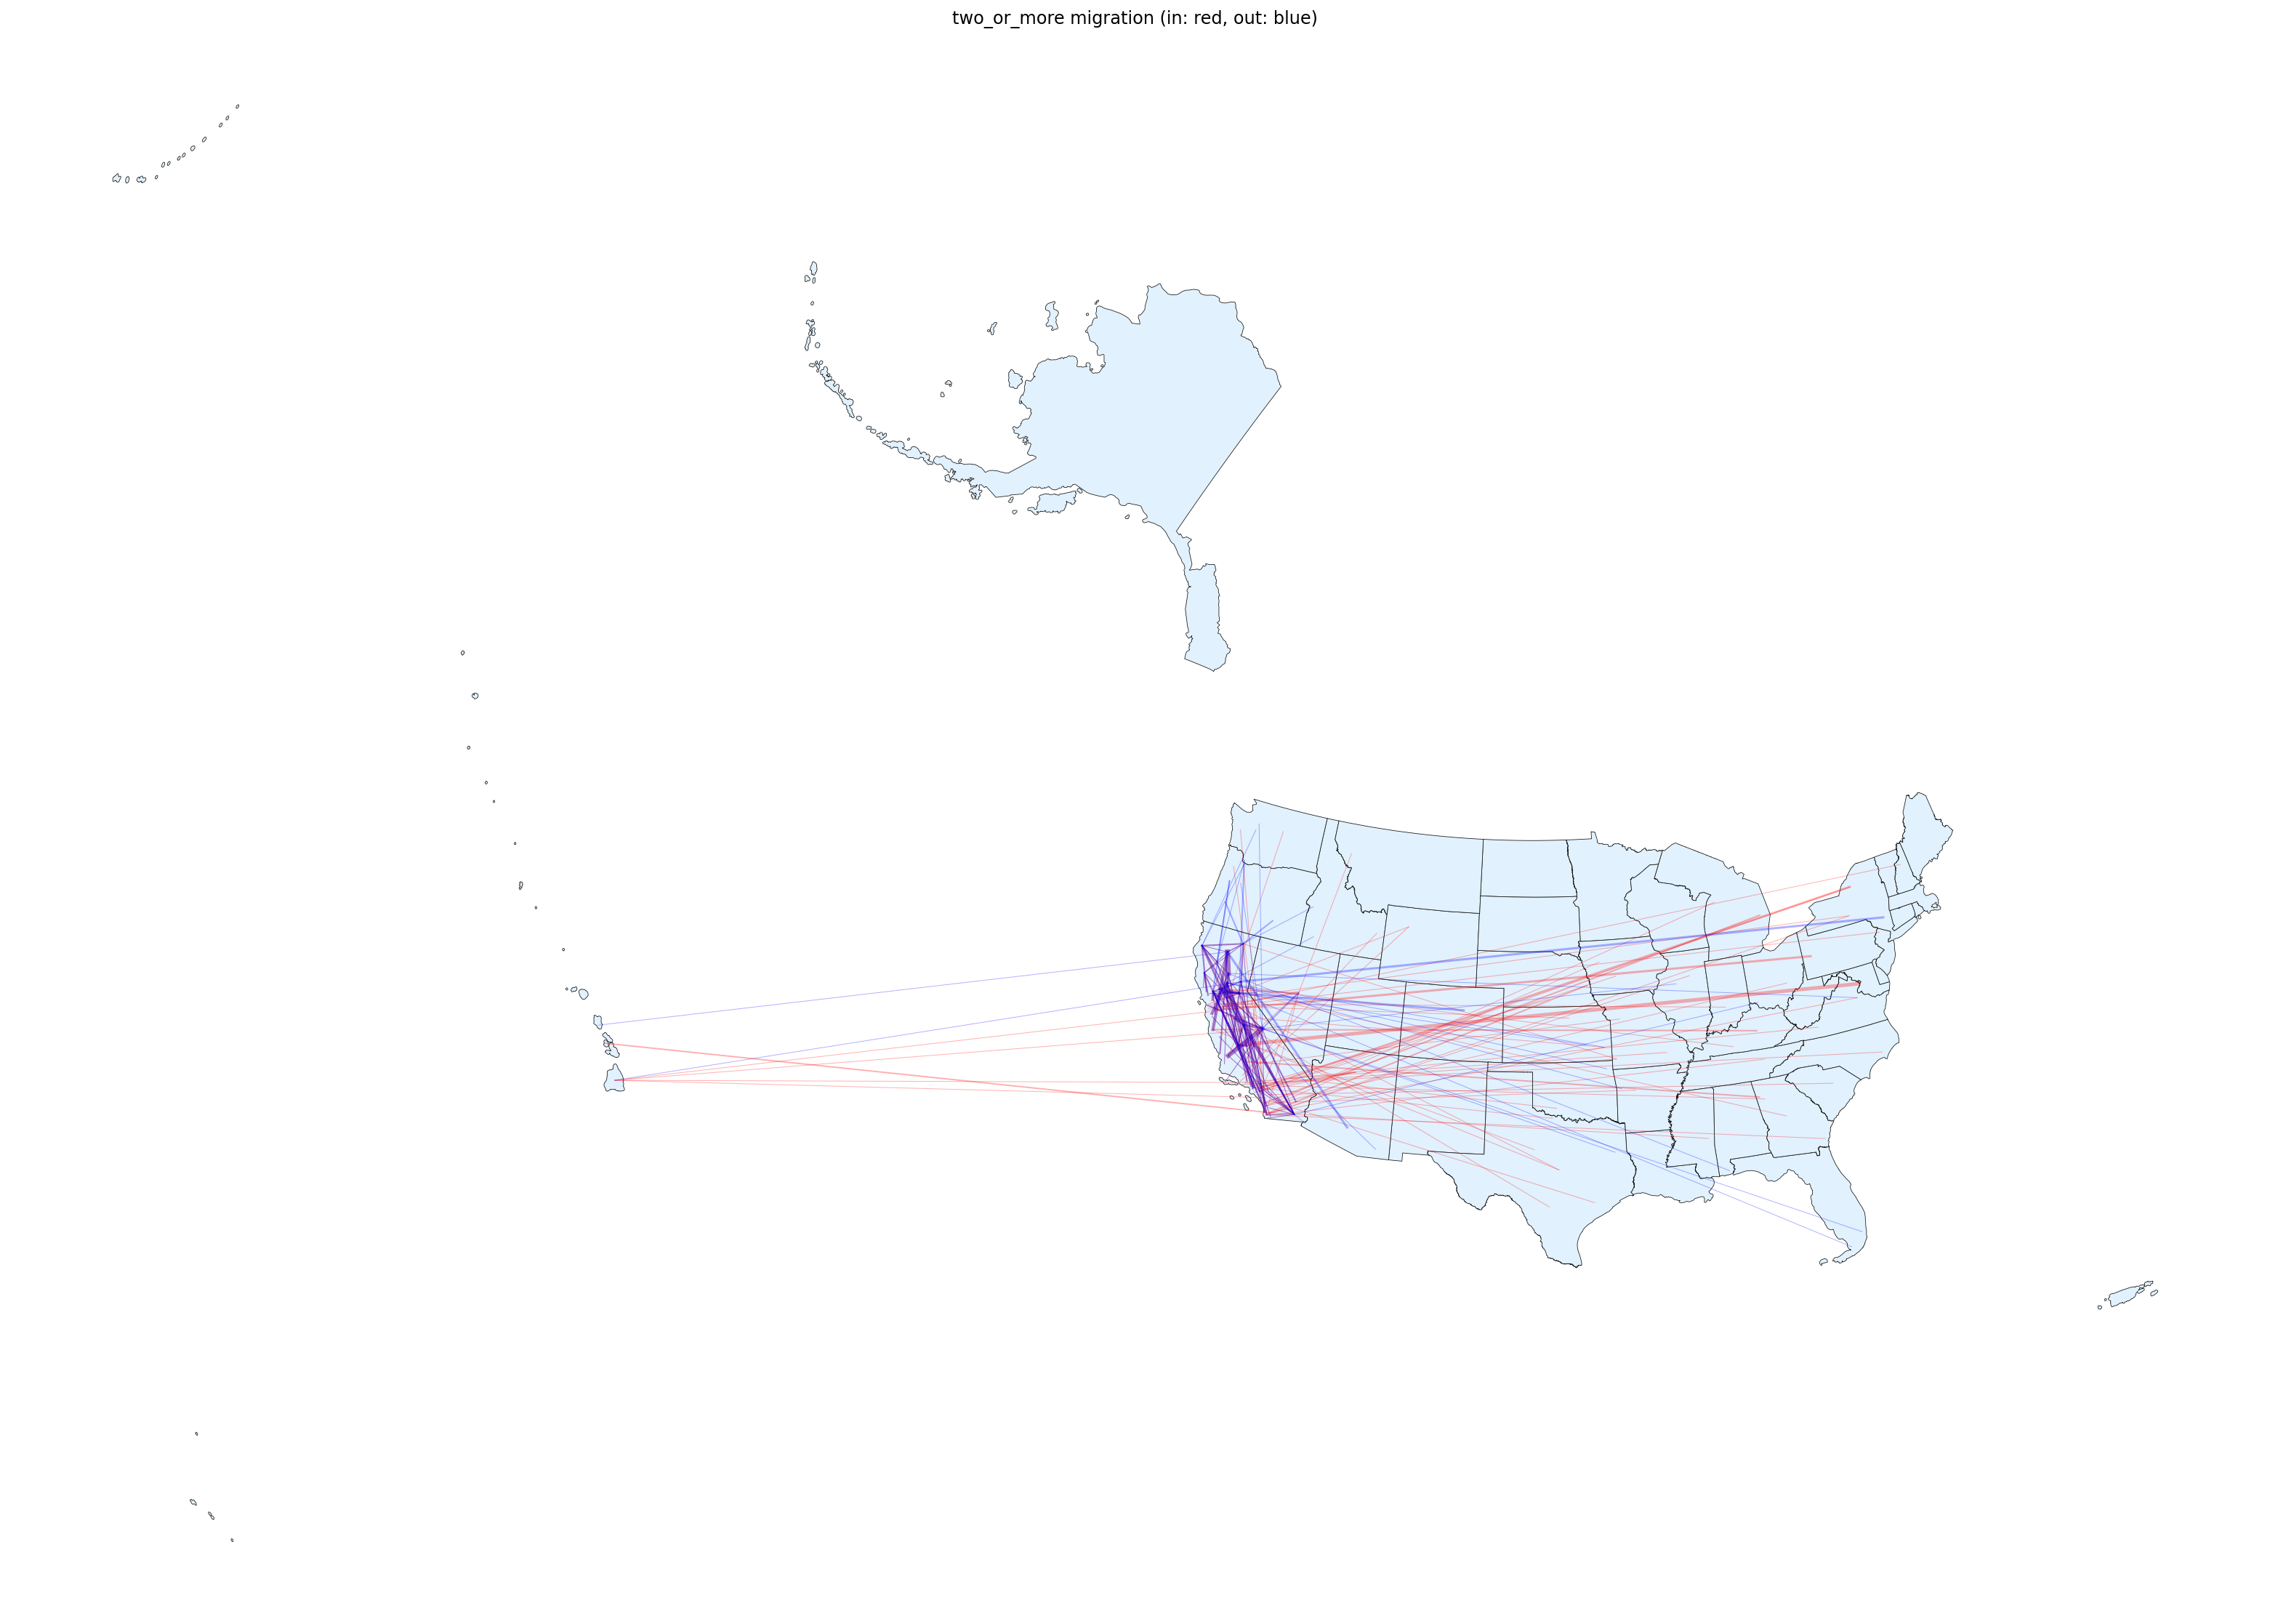

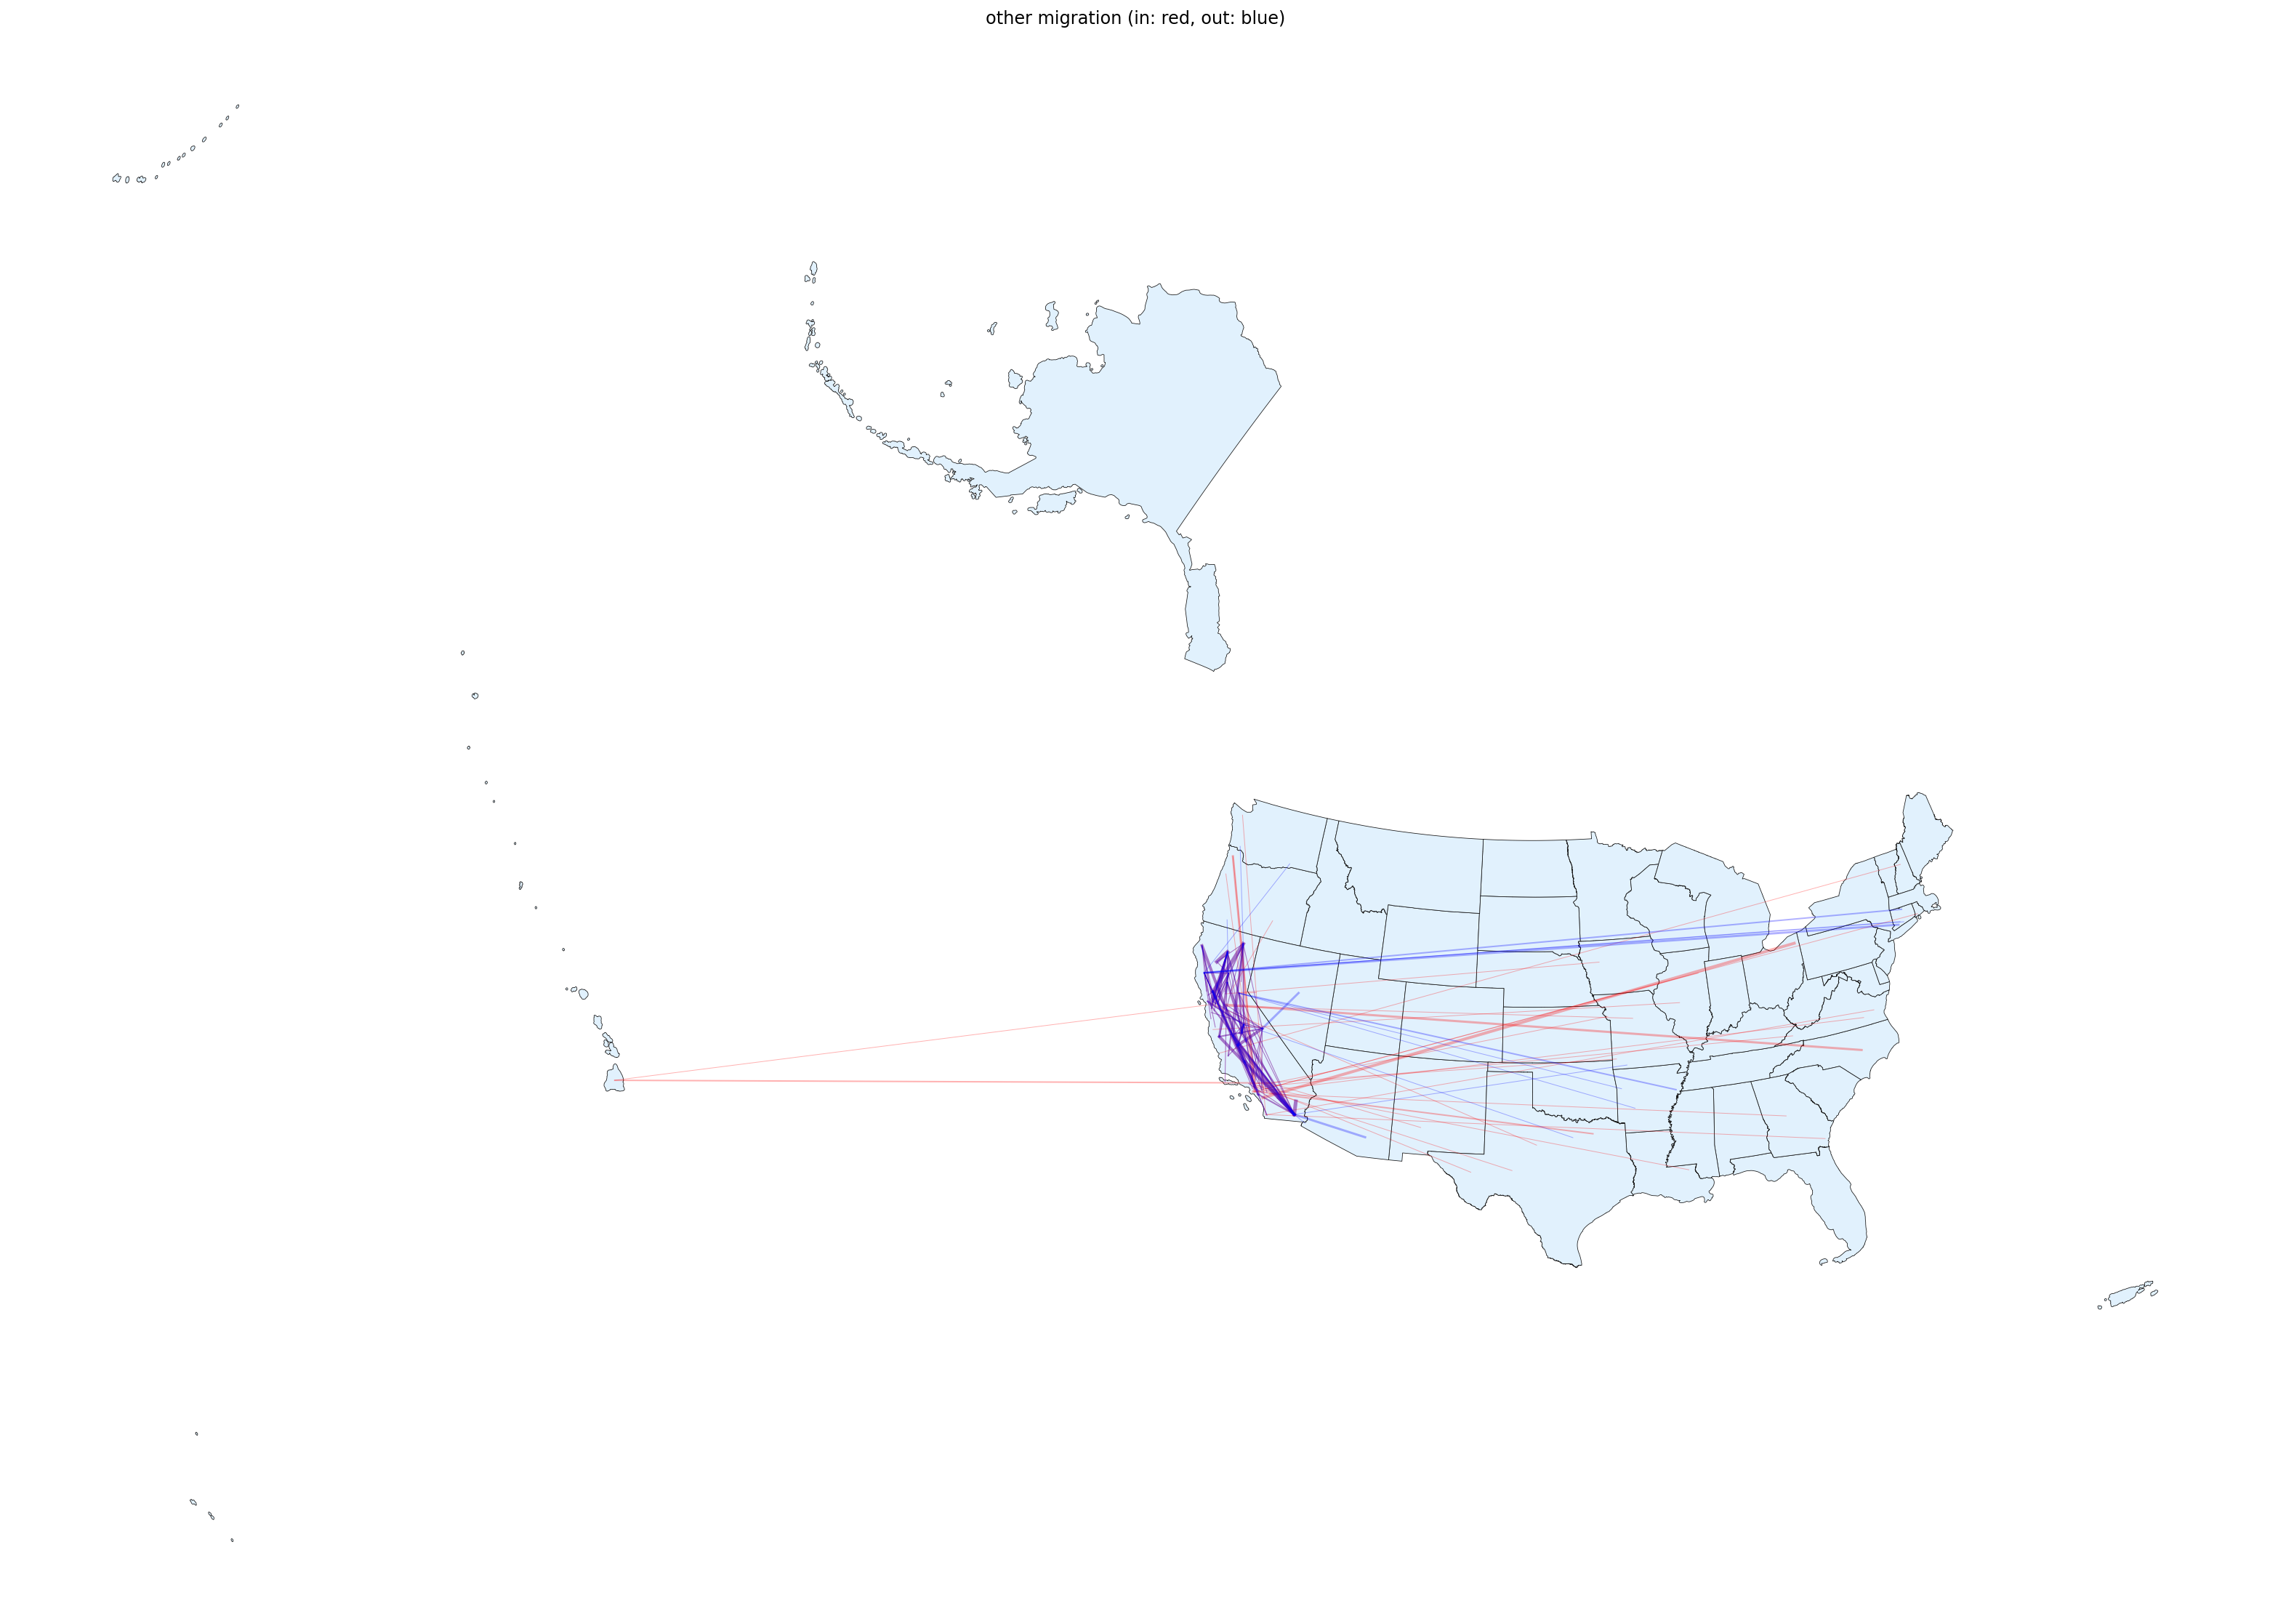

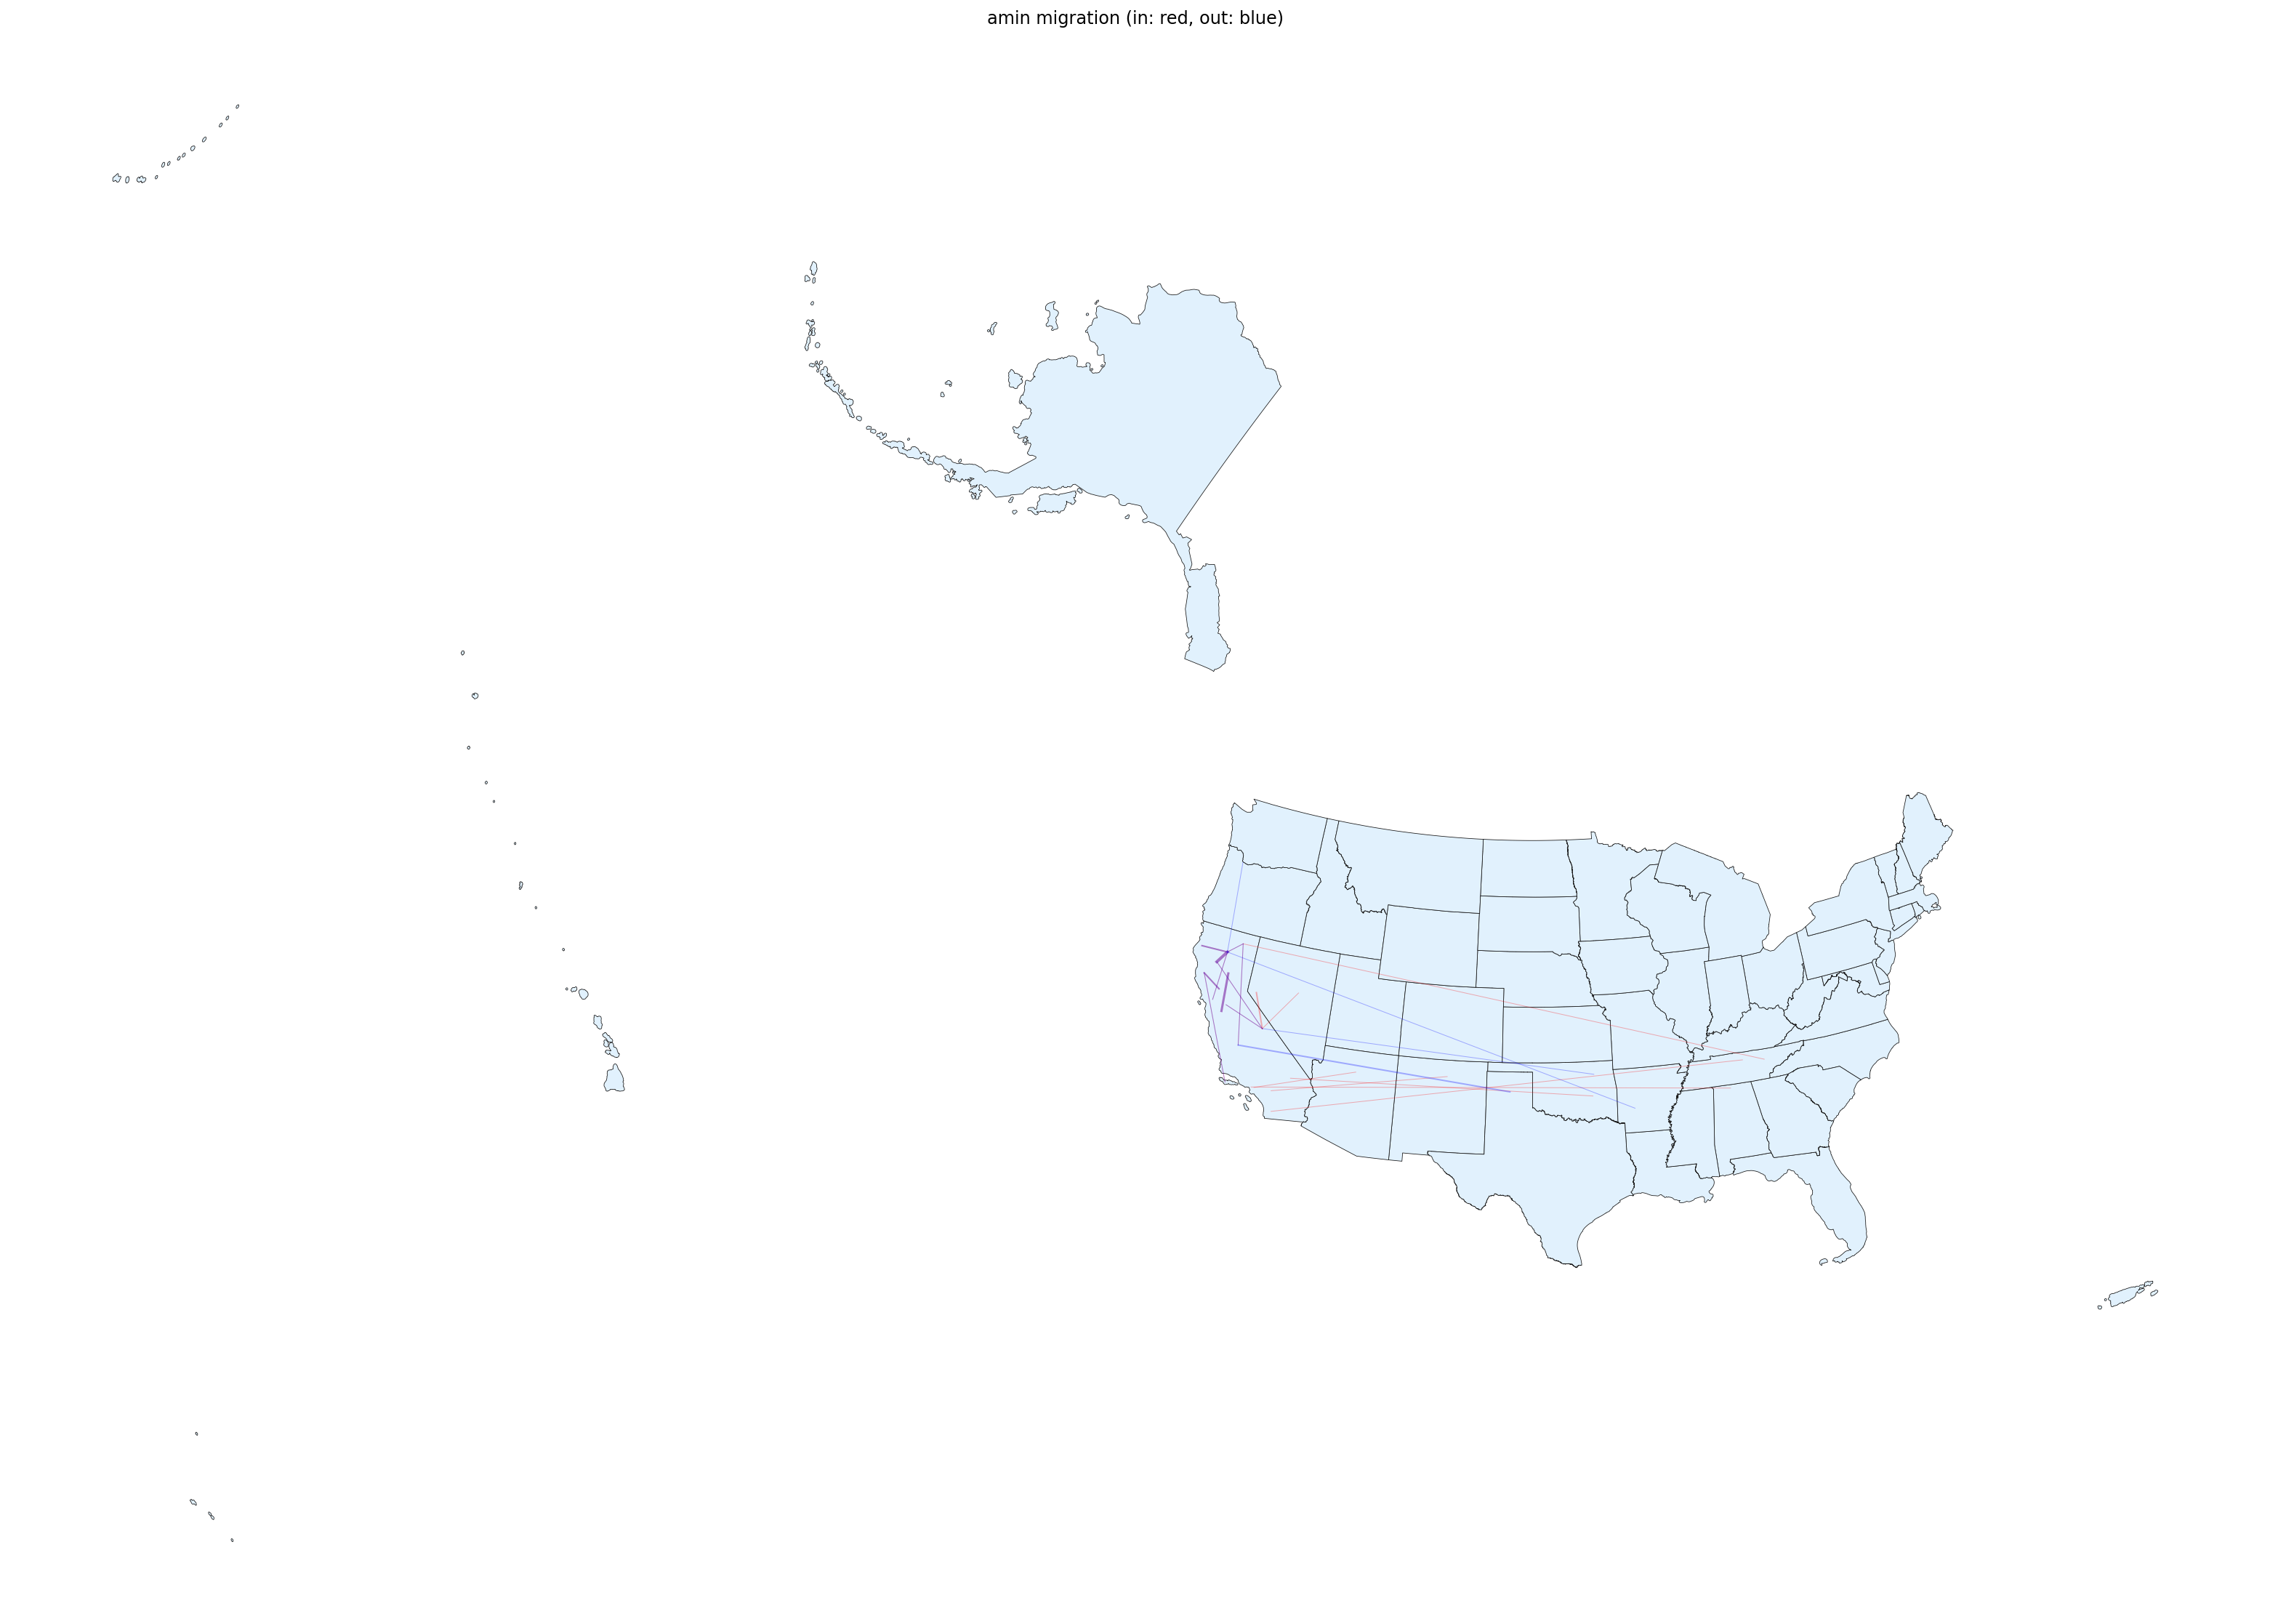

In [280]:
for race in puma_flows_df["race"].unique():
        race_flows_df = puma_flows_df[puma_flows_df["race"] == race]
        in_flow_counts = race_flows_df[race_flows_df["to"].str.startswith(flow_state)].groupby(by=["from", "to"]).size()
        out_flow_counts = race_flows_df[race_flows_df["from"].str.startswith(flow_state)].groupby(by=["from", "to"]).size()

        ax = state_gdf.plot(
            figsize=(40, 20),
            edgecolor="0.1",
            linewidth=0.4,
            color="#e1f1fd",
        )

        for flow_counts, color in zip((in_flow_counts, out_flow_counts), ("red", "blue")):
            for (flow_from, flow_to), count in flow_counts.items():
                try:
                    from_x, from_y = proj_puma_points[flow_from].coords.xy
                    to_x, to_y = proj_puma_points[flow_to].coords.xy
                except KeyError:
                    continue

                ax.plot([from_x[0], to_x[0]], [from_y[0], to_y[0]], color=color, linewidth=0.5 * count, alpha=0.3)

        ax.axis("off")
        ax.set_title(f"{race} migration (in: red, out: blue)")
        plt.show()